In [1]:
import sys
sys.path.append('..')

import optimus

In [2]:
frequency = 500e3 #Hz = 
a = 0.003 #3cm
D = 0.18 #18 cm
centroid_file='Data/default_random_array_centroid_locations.dat'
source = optimus.source.create_array(frequency, element_radius=a, centroid_locations_filename=centroid_file,
                                     location=[-D, 0, 0], number_of_point_sources_per_wavelength=2, velocity=0.4)

In [3]:
sphere_radius = 7.5e-3
geometry = optimus.geometry.shapes.Sphere(radius=7.5e-3, element_size=0.75e-3)
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

<IPython.core.display.Javascript object>


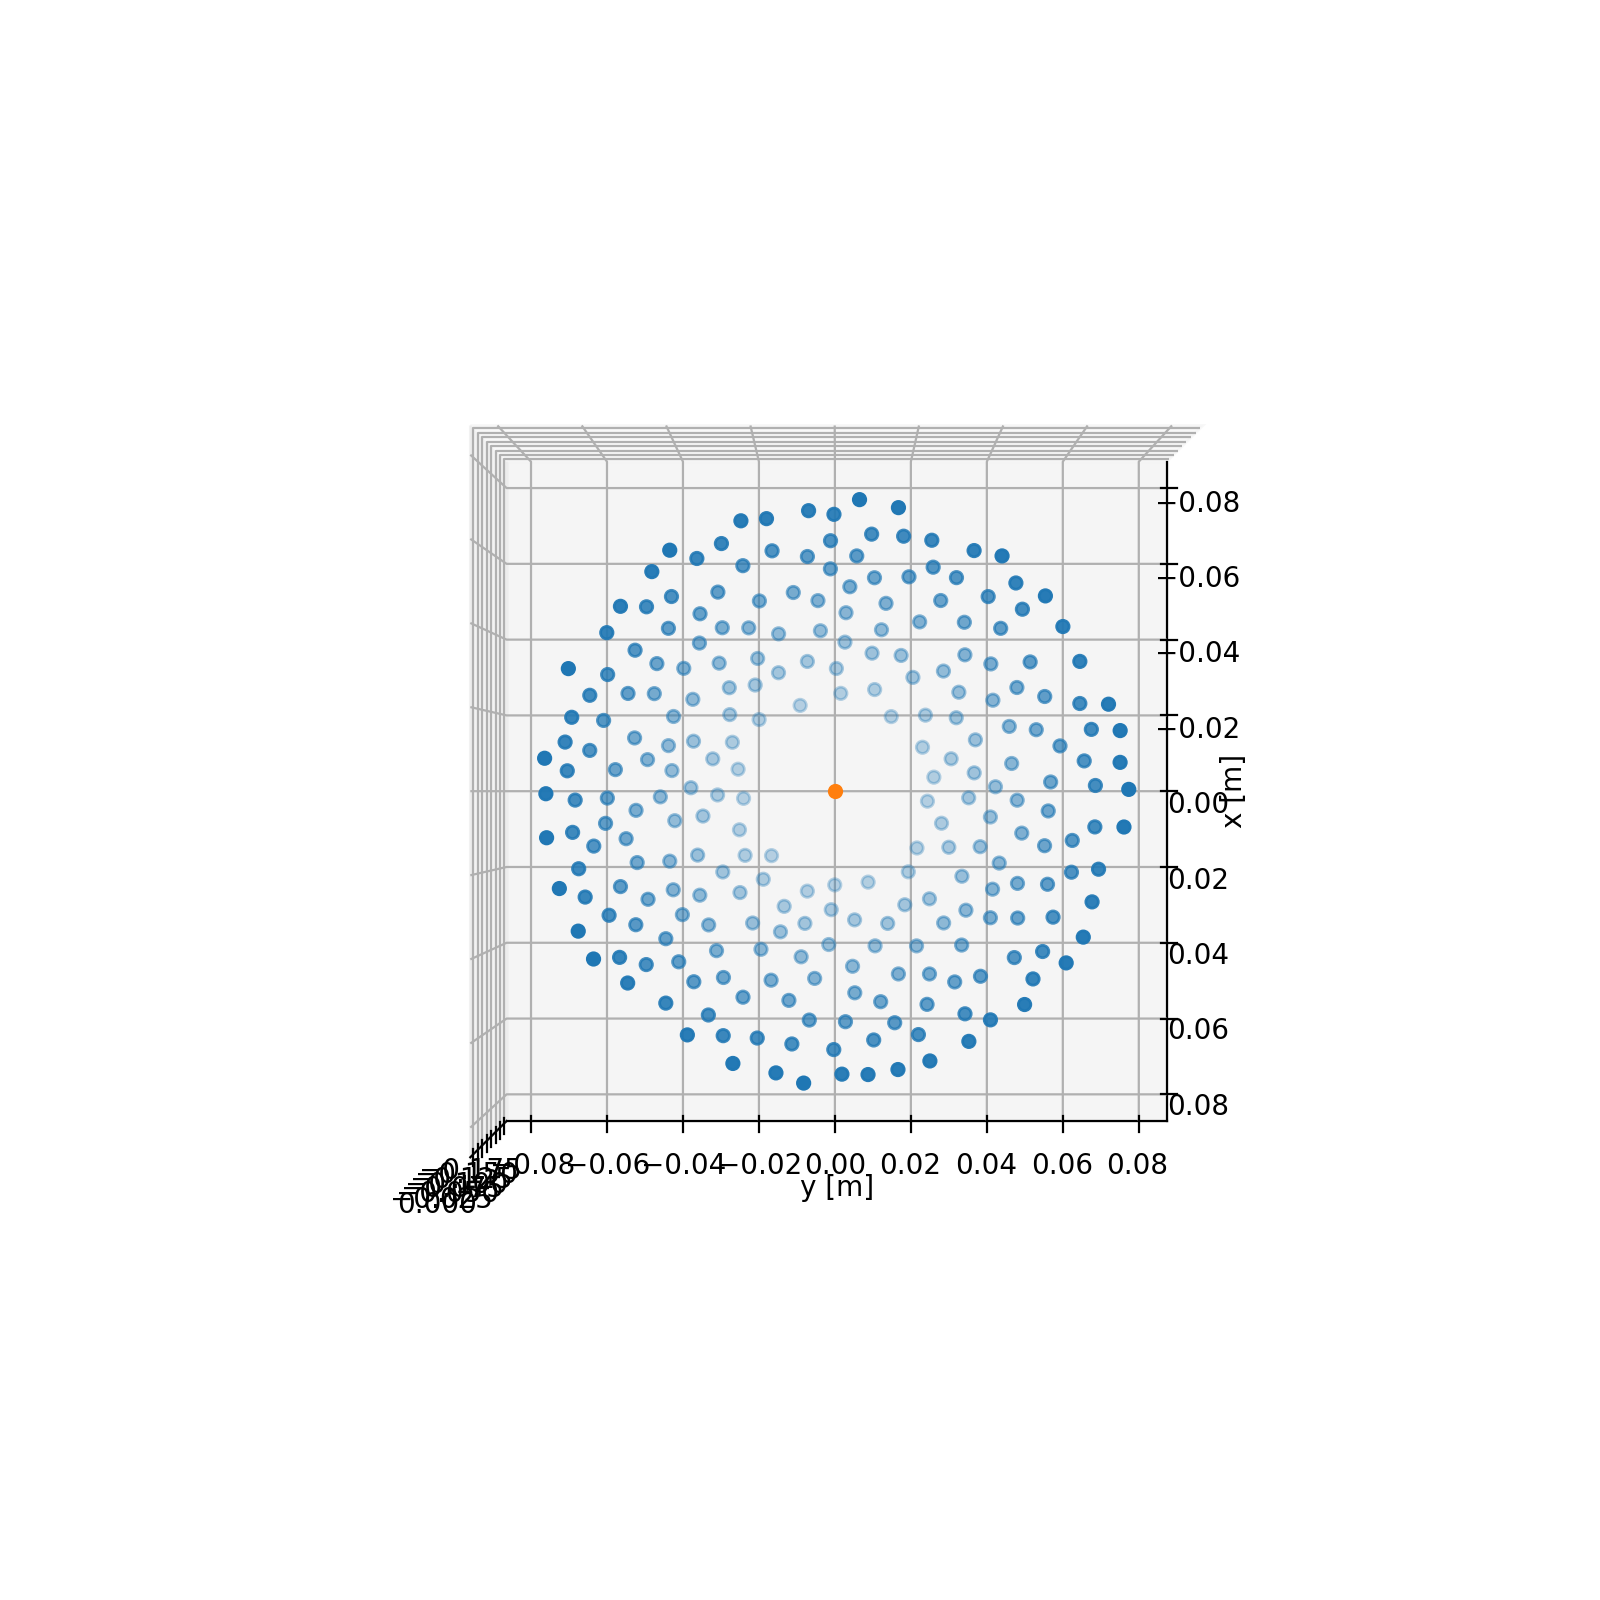

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

x = source.centroid_locations[0, :]
y = source.centroid_locations[1, :]
z = source.centroid_locations[2, :]

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.scatter(x, y, z)
ax.scatter(0, 0, 0, 'r')
ax.set_aspect('equal')
ax.view_init(90, 0)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
plt.show()

In [5]:
import numpy as np
Nx = 201
Ny = 101
xmin, xmax, ymin, ymax = [-D, D, -0.05, 0.05]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

In [6]:
%%time
from optimus.source.transducers import transducer_field
inc_field = transducer_field(source, material_ext, points, verbose=True)
incident_pressure = inc_field.pressure.reshape([Nx, Ny])

Number of point sources across element diameter: 5
Number of point sources in transducer: 3328
Parallelisation library is: numba
CPU times: user 8min 27s, sys: 173 ms, total: 8min 27s
Wall time: 1min 14s


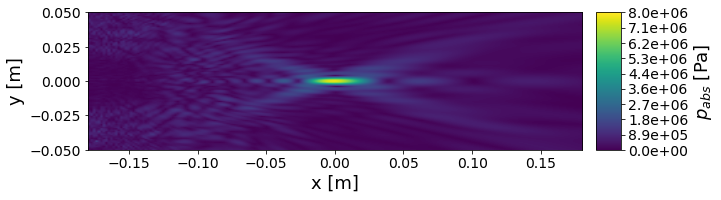

In [7]:
%matplotlib inline
from optimus.postprocess.plot import surface_plot

incident_pressure_plot = optimus.postprocess.common.array_to_imshow(incident_pressure)

theta = np.linspace(0, 2*np.pi, 100)
edge_sphere = (geometry.origin[0] + geometry.radius * np.cos(theta),
               geometry.origin[1] + geometry.radius * np.sin(theta))

fig = surface_plot(np.abs(incident_pressure_plot),
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[0,8e6],
                   colorbar_unit="$p_{abs}$ [Pa]",
                   )

In [8]:
c_0 = material_ext.speed_of_sound
rho_0 = material_ext.density
C_t = material_ext.heat_capacity
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b #attenuation_pow_b
P = incident_pressure_plot.copy()

In [19]:
material_ext.

  name     density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 water  994.035466          1482.3             0.025328                1.0


In [9]:
%%time
I = (np.abs(P))**2 / (c_0 * rho_0)

CPU times: user 7.21 ms, sys: 0 ns, total: 7.21 ms
Wall time: 4.38 ms


In [10]:
alpha_0 = 70 #dB/m
alpha = alpha_0 * frequency / 1000000
Q = I.copy()

In [11]:
%%time
Q = 2 * alpha * I

CPU times: user 4.29 ms, sys: 0 ns, total: 4.29 ms
Wall time: 3.29 ms


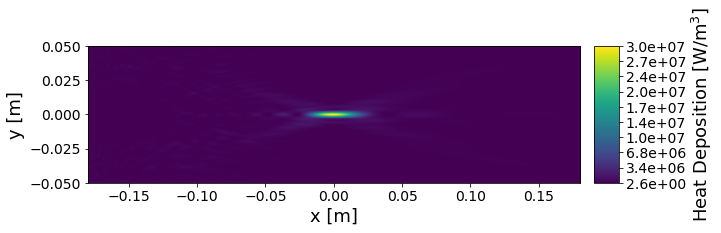

In [22]:
# PLOT Q
fig = surface_plot(np.abs(Q),
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(Q),np.max(Q)],
                   colorbar_unit="Heat Deposition [W/m$^3$]",
                   )

In [1]:
num_x = Q.shape[1]
num_y = Q.shape[0]

delta_x = (xmax - xmin) / num_x
delta_y = (ymax - ymin) / num_x
delta_t = 2

NameError: name 'Q' is not defined

In [25]:
t_0 = 37

T_0 = np.zeros_like(Q) + t_0

aux = T_0.copy()

In [26]:
Temps = [T_0]

In [27]:
%%time

#x entre 0 y 200
#y entre 0 y 100

T_1 = T_0.copy()
for y in range(len(Q)):
    for x in range(len(Q[0])):
        if (x != 0) and (x != 200) and (y != 0) and (y != 100):
            T_1[y, x] = T_0[y, x] + k_t * delta_t * ((T_0[y, x-1] - 2 * T_0[y, x] + T_0[y, x+1]) / (delta_x ** 2) + (T_0[y-1, x] - 2 * T_0[y, x] + T_0[y+1, x]) / (delta_y ** 2)) / (rho_0 * C_t) + Q[y, x] * delta_y / (rho_0 * C_t)

CPU times: user 525 ms, sys: 880 µs, total: 526 ms
Wall time: 523 ms


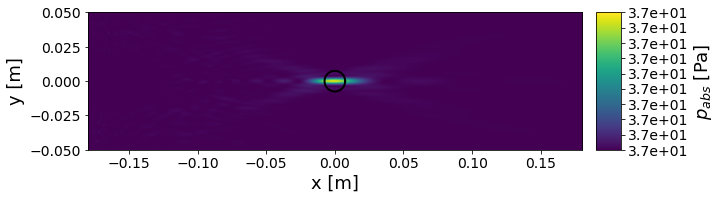

In [33]:
fig = surface_plot(np.abs(T_1),
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_1),np.max(T_1)],
                   colorbar_unit="$p_{abs}$ [Pa]",
                   domains_edges=[edge_sphere],
                   )

In [29]:
T_2 = T_1.copy()
for y in range(len(Q)):
    for x in range(len(Q[0])):
        if (x != 0) and (x != 200) and (y != 0) and (y != 100):
            T_2[y, x] = T_1[y, x] + k_t * delta_t * ((T_1[y, x-1] - 2 * T_1[y, x] + T_1[y, x+1]) / (delta_x ** 2) + (T_1[y-1, x] - 2 * T_1[y, x] + T_1[y+1, x]) / (delta_y ** 2)) / (rho_0 * C_t) + Q[y, x] * delta_y / (rho_0 * C_t)

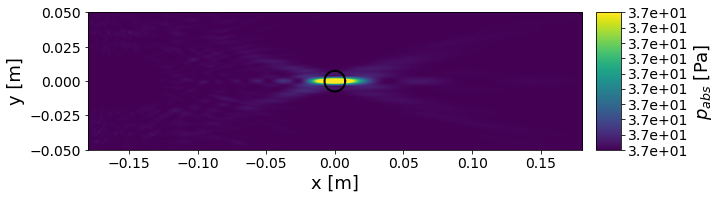

In [31]:
fig = surface_plot(np.abs(T_2),
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_1),np.max(T_1)],
                   colorbar_unit="$p_{abs}$ [Pa]",
                   domains_edges=[edge_sphere],
                   )

In [77]:
from matplotlib.animation import FuncAnimation

fig,ax = plt.subplots()
snapshots = np.asanyarray(pressure_fields_bem_time_plot[:, :, :]/p_scaling)
im = plt.imshow(snapshots[:,:,0],animated=True, extent=np.array(EXTENT)/d_scaling, clim = (-clim, clim), cmap = "seismic")
fig.gca().add_artist(plt.Circle((0,0), RADIUS/d_scaling, edgecolor='k', fill=False))

def animate(i):
    im.set_array(snapshots[:,:,i])
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    

animated_fig = FuncAnimation(fig, animate, frames=len(time_plot), interval=200, blit=True)
plt.show()

37.006849404356686